# Promoter CNN Model (Sequence Only)

A Convolutional Neural Network that predicts component probabilities from promoter sequences.
Chromosome feature has been removed to focus only on sequence information.

This notebook implements a CNN model for predicting component probabilities from DNA promoter sequences, providing an end-to-end solution for:
- Data loading and preprocessing
- Model architecture definition
- Training and validation
- Performance evaluation
- Visualization of results

In [23]:
#!/usr/bin/env python3
"""
Required imports for the CNN model implementation
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0
CUDA available: False


## Data Processing and Dataset Class

The `PromoterDataset` class handles the preprocessing of DNA sequences:
- Encodes DNA sequences into numerical representations
- Converts sequences to one-hot encoding for CNN input
- Handles sequence length standardization

In [24]:
class PromoterDataset(Dataset):
    """Dataset for promoter sequences only"""
    
    def __init__(self, sequences: list, targets: np.ndarray):
        self.sequences = sequences
        self.targets = targets
        
        # DNA encoding dictionary
        self.dna_dict = {'A': 0, 'T': 1, 'G': 2, 'C': 3, 'N': 4}
        
    def __len__(self):
        return len(self.sequences)
    
    def encode_sequence(self, sequence: str, max_length: int = 1000) -> np.ndarray:
        """Encode DNA sequence to numerical representation"""
        # Truncate or pad sequence
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence = sequence + 'N' * (max_length - len(sequence))
        
        # Convert to numerical encoding
        encoded = np.array([self.dna_dict.get(base.upper(), 4) for base in sequence])
        
        # One-hot encode
        one_hot = np.zeros((max_length, 5))
        one_hot[np.arange(max_length), encoded] = 1
        
        return one_hot.T  # Shape: (5, max_length) for Conv1d
    
    def __getitem__(self, idx):
        sequence = self.encode_sequence(self.sequences[idx])
        target = self.targets[idx]
        
        return {
            'sequence': torch.FloatTensor(sequence),
            'target': torch.FloatTensor(target)
        }

## Simple CNN Model Architecture

The `PromoterCNN` class implements a lightweight convolutional neural network:

- **Input**: One-hot encoded DNA sequences (5 channels: A, T, G, C, N)
- **Architecture**: Two simple convolutional blocks + global pooling
- **Output**: 4-component probability distribution (softmax normalized)

This simplified model focuses on fast training while still capturing sequence patterns.

In [25]:
import torch.nn as nn

class PromoterCNN(nn.Module):
    """Simplified CNN for predicting component probabilities from promoter sequences"""
    
    def __init__(self, sequence_length: int = 1000):
        super(PromoterCNN, self).__init__()
        
        self.sequence_conv = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Dropout(0.2),
            
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Reduce to [batch, 64, 1]
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 4),
            nn.Softmax(dim=1)
        )
        
    def forward(self, sequence):
        x = self.sequence_conv(sequence)
        x = x.squeeze(-1)  # Flatten to [batch, 64]
        output = self.classifier(x)
        return output


## Data Loading and Preparation

Functions for loading the processed data and preparing it for training:

In [26]:
def load_and_prepare_data(file_path: str) -> Tuple[list, np.ndarray]:
    """Load and prepare data for training"""
    print("Loading data...")
    df = pd.read_csv(file_path)
    
    # Component probabilities as targets
    prob_cols = ['Component_1_Probability', 'Component_2_Probability', 
                'Component_3_Probability', 'Component_4_Probability']
    
    # Filter out rows with missing sequence data or target data
    print(f"Initial data shape: {df.shape}")
    
    # Remove rows with NaN in ProSeq column
    df = df.dropna(subset=['ProSeq'])
    print(f"After removing missing sequences: {df.shape}")
    
    # Remove rows with NaN in any probability column
    df = df.dropna(subset=prob_cols)
    print(f"After removing missing probabilities: {df.shape}")
    
    # Extract features and targets
    sequences = df['ProSeq'].tolist()
    targets = df[prob_cols].values
    
    # Additional validation - ensure all sequences are strings
    valid_sequences = []
    valid_targets = []
    
    for i, seq in enumerate(sequences):
        if isinstance(seq, str) and len(seq) > 0:
            valid_sequences.append(seq)
            valid_targets.append(targets[i])
    
    sequences = valid_sequences
    targets = np.array(valid_targets)
    
    print(f"Final dataset: {len(sequences)} samples")
    print(f"Average sequence length: {np.mean([len(seq) for seq in sequences]):.1f}")
    print(f"Min sequence length: {min([len(seq) for seq in sequences])}")
    print(f"Max sequence length: {max([len(seq) for seq in sequences])}")
    
    return sequences, targets

## Training and Validation Functions

Functions for training and validating the model:

In [27]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    
    for batch in train_loader:
        sequences = batch['sequence'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            sequences = batch['sequence'].to(device)
            targets = batch['target'].to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

def evaluate_model(model, test_loader, device):
    """Evaluate the trained model"""
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            sequences = batch['sequence'].to(device)
            targets = batch['target'].to(device)
            
            outputs = model(sequences)
            
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    return predictions, targets

## Visualization and Results Analysis

Functions for plotting training results and model performance:

In [28]:
def plot_results(train_losses, val_losses, metrics, predictions, targets):
    """Plot training results and model performance"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Training curves
    axes[0, 0].plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].set_title('Training Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # R2 scores by component
    component_names_short = ['Comp_1', 'Comp_2', 'Comp_3', 'Comp_4']
    r2_scores = [metrics[f'Component_{i+1}']['R2'] for i in range(4)]
    colors = ['blue', 'orange', 'green', 'red']
    
    axes[0, 1].bar(component_names_short, r2_scores, color=colors, alpha=0.7)
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].set_title('R² Scores by Component')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 1)
    
    # MSE by component
    mse_scores = [metrics[f'Component_{i+1}']['MSE'] for i in range(4)]
    
    axes[0, 2].bar(component_names_short, mse_scores, color=colors, alpha=0.7)
    axes[0, 2].set_ylabel('MSE')
    axes[0, 2].set_title('MSE by Component')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Prediction vs actual scatter plots for each component
    for i in range(3):
        row = 1
        col = i
        
        axes[row, col].scatter(targets[:, i], predictions[:, i], alpha=0.5, s=10, color=colors[i])
        axes[row, col].plot([0, 1], [0, 1], 'r--', alpha=0.8)
        axes[row, col].set_xlabel('Actual Probability')
        axes[row, col].set_ylabel('Predicted Probability')
        axes[row, col].set_title(f'Component {i+1} (R² = {metrics[f"Component_{i+1}"]["R2"]:.3f})')
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].set_xlim(0, 1)
        axes[row, col].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('cnn_results.png', dpi=300, bbox_inches='tight')
    plt.show()

## Prediction Function

Function for making predictions on new sequences:

In [29]:
def predict_component_probabilities(model, sequence: str, device) -> dict:
    """Predict component probabilities for a new sequence"""
    
    model.eval()
    
    # Create temporary dataset for encoding
    temp_dataset = PromoterDataset([sequence], np.array([[0, 0, 0, 0]]))
    
    # Encode sequence
    encoded_seq = temp_dataset.encode_sequence(sequence)
    
    # Convert to tensor
    sequence_tensor = torch.FloatTensor(encoded_seq).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(sequence_tensor)
    
    probabilities = output.cpu().numpy()[0]
    predicted_component = np.argmax(probabilities) + 1
    confidence = np.max(probabilities)
    
    return {
        'component_1_prob': float(probabilities[0]),
        'component_2_prob': float(probabilities[1]),
        'component_3_prob': float(probabilities[2]),
        'component_4_prob': float(probabilities[3]),
        'predicted_component': int(predicted_component),
        'confidence': float(confidence),
        'interpretation': f"Predicted Component {predicted_component} with {confidence:.1%} confidence"
    }

## Main Execution Pipeline

Now let's run the complete training and evaluation pipeline:

In [30]:
# Load data
sequences, targets = load_and_prepare_data('../Processed-Data/ProSeq_with_4component_analysis.csv')

# Show data statistics
print(f"\nData statistics:")
print(f"Total samples: {len(sequences)}")
print(f"Target shape: {targets.shape}")
for i in range(4):
    print(f"  Component {i+1}: {targets[:, i].min():.4f} - {targets[:, i].max():.4f} (mean: {targets[:, i].mean():.4f})")

Loading data...
Initial data shape: (8739, 15)
After removing missing sequences: (8735, 15)
After removing missing probabilities: (8735, 15)
Final dataset: 8735 samples
Average sequence length: 600.0
Min sequence length: 472
Max sequence length: 600

Data statistics:
Total samples: 8735
Target shape: (8735, 4)
  Component 1: 0.0000 - 0.9278 (mean: 0.4332)
  Component 2: 0.0000 - 1.0000 (mean: 0.0967)
  Component 3: 0.0000 - 1.0000 (mean: 0.1887)
  Component 4: 0.0000 - 0.9746 (mean: 0.2814)


In [31]:
# Split data
train_seq, test_seq, train_targets, test_targets = train_test_split(
    sequences, targets, test_size=0.2, random_state=42
)

train_seq, val_seq, train_targets, val_targets = train_test_split(
    train_seq, train_targets, test_size=0.2, random_state=42
)

print(f"\nData splits:")
print(f"  Train: {len(train_seq)}, Val: {len(val_seq)}, Test: {len(test_seq)}")

# Create datasets
train_dataset = PromoterDataset(train_seq, train_targets)
val_dataset = PromoterDataset(val_seq, val_targets)
test_dataset = PromoterDataset(test_seq, test_targets)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


Data splits:
  Train: 5590, Val: 1398, Test: 1747


In [ ]:
# Create model
model = PromoterCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel created with {total_params:,} parameters")
print(f"Training on: {device}")

# Training configuration
num_epochs = 50
learning_rate = 0.005

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)


Model created with 13,668 parameters
Training on: cpu


In [35]:
# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')

print(f"\nStarting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_promoter_cnn.pth')
    
    # Print progress
    print(f'Epoch [{epoch+1:3d}/{num_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')


Starting training for 50 epochs...
Epoch [  1/50] - Train Loss: 0.118082, Val Loss: 0.118863
Epoch [  2/50] - Train Loss: 0.118289, Val Loss: 0.119245
Epoch [  3/50] - Train Loss: 0.118027, Val Loss: 0.118880
Epoch [  4/50] - Train Loss: 0.117862, Val Loss: 0.118906
Epoch [  5/50] - Train Loss: 0.117873, Val Loss: 0.118838
Epoch [  6/50] - Train Loss: 0.117796, Val Loss: 0.119058
Epoch [  7/50] - Train Loss: 0.117744, Val Loss: 0.118834
Epoch [  8/50] - Train Loss: 0.117922, Val Loss: 0.118838
Epoch [  9/50] - Train Loss: 0.117673, Val Loss: 0.119032
Epoch [ 10/50] - Train Loss: 0.117762, Val Loss: 0.119054
Epoch [ 11/50] - Train Loss: 0.117554, Val Loss: 0.118804
Epoch [ 12/50] - Train Loss: 0.117556, Val Loss: 0.118865
Epoch [ 13/50] - Train Loss: 0.117718, Val Loss: 0.118859
Epoch [ 14/50] - Train Loss: 0.117614, Val Loss: 0.118825
Epoch [ 15/50] - Train Loss: 0.117570, Val Loss: 0.118864
Epoch [ 16/50] - Train Loss: 0.117698, Val Loss: 0.118721
Epoch [ 17/50] - Train Loss: 0.11755

In [36]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_promoter_cnn.pth'))
predictions, targets = evaluate_model(model, test_loader, device)

# Calculate metrics
component_names = ['Component_1', 'Component_2', 'Component_3', 'Component_4']
metrics = {}

print(f"\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)

for i, comp_name in enumerate(component_names):
    mse = mean_squared_error(targets[:, i], predictions[:, i])
    r2 = r2_score(targets[:, i], predictions[:, i])
    
    metrics[comp_name] = {'MSE': mse, 'R2': r2}
    print(f"{comp_name}: MSE = {mse:.6f}, R² = {r2:.4f}")

# Overall metrics
overall_mse = mean_squared_error(targets, predictions)
overall_r2 = r2_score(targets.flatten(), predictions.flatten())

metrics['Overall'] = {'MSE': overall_mse, 'R2': overall_r2}
print(f"\nOverall: MSE = {overall_mse:.6f}, R² = {overall_r2:.4f}")


MODEL EVALUATION RESULTS
Component_1: MSE = 0.154430, R² = 0.0075
Component_2: MSE = 0.068570, R² = 0.0024
Component_3: MSE = 0.092500, R² = 0.0304
Component_4: MSE = 0.151067, R² = 0.0046

Overall: MSE = 0.116642, R² = 0.1210


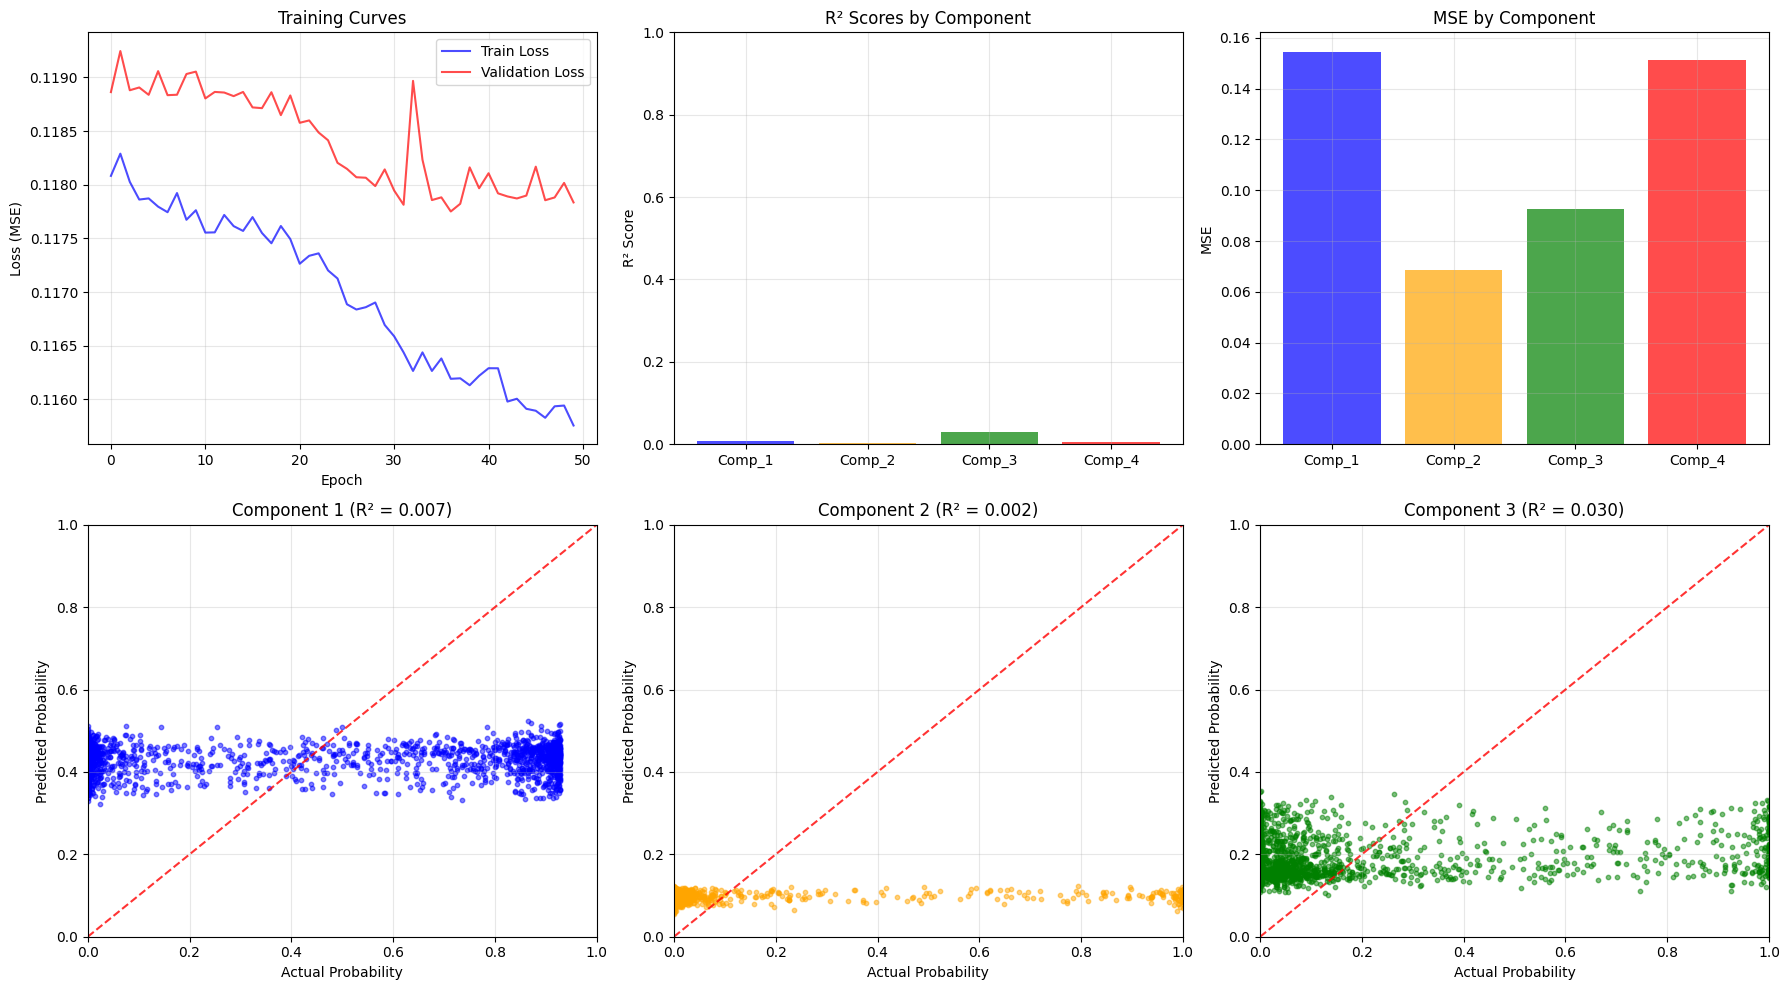

In [37]:
# Plot results
plot_results(train_losses, val_losses, metrics, predictions, targets)

In [38]:
# Test prediction function
print(f"\n" + "="*50)
print("TESTING PREDICTION FUNCTION")
print("="*50)

sample_seq = sequences[0]
sample_target = targets[0]

result = predict_component_probabilities(model, sample_seq, device)

print(f"Sample sequence length: {len(sample_seq)}")
print(f"Actual probabilities: {sample_target}")
print(f"\nCNN Predictions:")
for i in range(4):
    pred_key = f'component_{i+1}_prob'
    print(f"  Component {i+1}: {result[pred_key]:.4f} (actual: {sample_target[i]:.4f})")

print(f"\n{result['interpretation']}")
print(f"Actual component: {np.argmax(sample_target) + 1}")

print(f"\nModel saved as 'best_promoter_cnn.pth'")
print(f"Results plot saved as 'cnn_results.png'")


TESTING PREDICTION FUNCTION
Sample sequence length: 600
Actual probabilities: [9.2647648e-01 5.2267002e-05 4.9489509e-02 2.3981735e-02]

CNN Predictions:
  Component 1: 0.4739 (actual: 0.9265)
  Component 2: 0.0824 (actual: 0.0001)
  Component 3: 0.1365 (actual: 0.0495)
  Component 4: 0.3072 (actual: 0.0240)

Predicted Component 1 with 47.4% confidence
Actual component: 1

Model saved as 'best_promoter_cnn.pth'
Results plot saved as 'cnn_results.png'
